In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchmetrics.functional.regression import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


In [67]:
filename = "../DATA/oil_price.csv"
priceDF = pd.read_csv(filename, encoding="utf-8", parse_dates=["date"])
priceDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10329 non-null  datetime64[ns]
 1   price   10329 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 161.5 KB


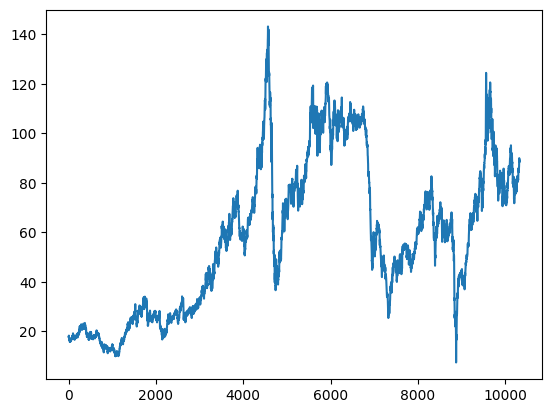

In [68]:
plt.plot(priceDF["price"], label="price")
plt.show()


In [69]:
class OilPriceDataset(Dataset):
    def __init__(self, data, step=365):
        data = data if isinstance(data, np.ndarray) else data.values
        self.max_data = np.max(data)
        self.min_data = np.min(data)
        self.data = (data - self.min_data) / (self.max_data - self.min_data)
        self.data = torch.FloatTensor(self.data)
        self.step = step

    def __len__(self):
        return len(self.data) - self.step

    def __getitem__(self, i):
        data = self.data[i : i + self.step]
        label = self.data[i + self.step].squeeze()
        return data, label


In [70]:
class OilPriceModel(nn.Module):
    def __init__(self, hidden_size, num_layers, step):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(in_features=hidden_size * step, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.flatten(x)


In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 32
num_layers = 2
step = 365
batch_size = 128

model = OilPriceModel(hidden_size, num_layers, step).to(device)
dataset = OilPriceDataset(priceDF[["price"]], step)
loader = DataLoader(dataset, batch_size)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

len(loader)


78

In [72]:
for i in loader:
    print(i[0].shape)
    break


torch.Size([128, 365, 1])


In [73]:
def learning(
    epochs, epoch, model, loader, optimizer, loss_fn, is_train=True, use_pbar=True
):
    if is_train:
        model.train()
    else:
        model.eval()

    lossList, maeList, mseList, r2List = [], [], [], []
    with torch.set_grad_enabled(is_train):
        pbar = tqdm(loader, total=len(loader)) if use_pbar else loader
        for data, label in pbar:
            pred = model(data.to(device))
            loss = loss_fn(pred, label.to(device))
            lossList.append(loss.item())
            maeList.append(mean_absolute_error(pred, label.to(device)).item())
            mseList.append(mean_squared_error(pred, label.to(device)).item())
            r2List.append(r2_score(pred, label.to(device)).item())
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if use_pbar:
                    pbar.set_description(
                        f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.6f}"
                    )
    return np.mean(lossList), np.mean(maeList), np.mean(mseList), np.mean(r2List)


In [74]:
pre_r2 = 0
pre_loss = 100


In [75]:
epochs = 100
for epoch in range(epochs):
    loss, mae, mse, r2 = learning(
        epochs, epoch, model, loader, optimizer, loss_fn, is_train=True, use_pbar=True
    )
    if epoch % 10 == 9:
        print(
            f"  ==== Loss: {loss:.6f} | MAE: {mae:.6f} | MSE: {mse:.6f} | R2: {r2:.6f} ===="
        )
    if pre_r2 < r2 or (pre_r2 <= r2 and pre_loss > loss):
        torch.save(model, f"oil_price_model_{step}.pth")
        torch.save(model.state_dict(), f"oil_price_model_state_{step}.pth")
        print(f"Model Saved! => R2: {r2:.6f} | Loss: {loss:.6f}")
        pre_r2 = r2
        pre_loss = loss
    scheduler.step(loss)


Epoch: 0/100 | Loss: 0.002362: 100%|██████████| 78/78 [00:26<00:00,  2.95it/s]
Epoch: 1/100 | Loss: 0.006891: 100%|██████████| 78/78 [00:27<00:00,  2.86it/s]
Epoch: 2/100 | Loss: 0.007261: 100%|██████████| 78/78 [00:27<00:00,  2.89it/s]
Epoch: 3/100 | Loss: 0.010523: 100%|██████████| 78/78 [00:28<00:00,  2.75it/s]
Epoch: 4/100 | Loss: 0.000915: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
Epoch: 5/100 | Loss: 0.002319: 100%|██████████| 78/78 [00:32<00:00,  2.37it/s]
Epoch: 6/100 | Loss: 0.004908: 100%|██████████| 78/78 [00:27<00:00,  2.86it/s]
Epoch: 7/100 | Loss: 0.000850: 100%|██████████| 78/78 [00:27<00:00,  2.85it/s]
Epoch: 8/100 | Loss: 0.000725: 100%|██████████| 78/78 [00:27<00:00,  2.83it/s]
Epoch: 9/100 | Loss: 0.004623: 100%|██████████| 78/78 [00:28<00:00,  2.73it/s]


  ==== Loss: 0.004746 | MAE: 0.050609 | MSE: 0.004746 | R2: -11.949778 ====


Epoch: 10/100 | Loss: 0.005205: 100%|██████████| 78/78 [00:32<00:00,  2.41it/s]
Epoch: 11/100 | Loss: 0.003751: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
Epoch: 12/100 | Loss: 0.001099: 100%|██████████| 78/78 [00:32<00:00,  2.37it/s]
Epoch: 13/100 | Loss: 0.000999: 100%|██████████| 78/78 [00:28<00:00,  2.77it/s]
Epoch: 14/100 | Loss: 0.001217: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]
Epoch: 15/100 | Loss: 0.002700: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]
Epoch: 16/100 | Loss: 0.002451: 100%|██████████| 78/78 [00:31<00:00,  2.52it/s]
Epoch: 17/100 | Loss: 0.002132: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]
Epoch: 18/100 | Loss: 0.001881: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s]
Epoch: 19/100 | Loss: 0.002065: 100%|██████████| 78/78 [00:29<00:00,  2.66it/s]


  ==== Loss: 0.003568 | MAE: 0.047977 | MSE: 0.003568 | R2: -20.774582 ====


Epoch: 20/100 | Loss: 0.002193: 100%|██████████| 78/78 [00:27<00:00,  2.83it/s]
Epoch: 21/100 | Loss: 0.002332: 100%|██████████| 78/78 [00:28<00:00,  2.70it/s]
Epoch: 22/100 | Loss: 0.003088: 100%|██████████| 78/78 [00:31<00:00,  2.45it/s]
Epoch: 23/100 | Loss: 0.004238: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]
Epoch: 24/100 | Loss: 0.002416: 100%|██████████| 78/78 [00:35<00:00,  2.17it/s]
Epoch: 25/100 | Loss: 0.001143: 100%|██████████| 78/78 [00:28<00:00,  2.71it/s]
Epoch: 26/100 | Loss: 0.000712: 100%|██████████| 78/78 [00:28<00:00,  2.78it/s]
Epoch: 27/100 | Loss: 0.000855: 100%|██████████| 78/78 [00:29<00:00,  2.68it/s]
Epoch: 28/100 | Loss: 0.000816: 100%|██████████| 78/78 [00:32<00:00,  2.37it/s]
Epoch: 29/100 | Loss: 0.000965: 100%|██████████| 78/78 [00:38<00:00,  2.02it/s]


  ==== Loss: 0.001420 | MAE: 0.028974 | MSE: 0.001420 | R2: -3.385229 ====


Epoch: 30/100 | Loss: 0.001164: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
Epoch: 31/100 | Loss: 0.001582: 100%|██████████| 78/78 [00:27<00:00,  2.80it/s]
Epoch: 32/100 | Loss: 0.001822: 100%|██████████| 78/78 [00:27<00:00,  2.79it/s]
Epoch: 33/100 | Loss: 0.002120: 100%|██████████| 78/78 [00:29<00:00,  2.62it/s]
Epoch: 34/100 | Loss: 0.002516: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
Epoch: 35/100 | Loss: 0.002611: 100%|██████████| 78/78 [00:39<00:00,  1.98it/s]
Epoch: 36/100 | Loss: 0.002804: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
Epoch: 37/100 | Loss: 0.002858: 100%|██████████| 78/78 [00:27<00:00,  2.81it/s]
Epoch: 38/100 | Loss: 0.002920: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]
Epoch: 39/100 | Loss: 0.002200: 100%|██████████| 78/78 [00:29<00:00,  2.61it/s]


  ==== Loss: 0.000961 | MAE: 0.023449 | MSE: 0.000961 | R2: -0.964781 ====


Epoch: 40/100 | Loss: 0.002018: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]
Epoch: 41/100 | Loss: 0.002831: 100%|██████████| 78/78 [00:38<00:00,  2.02it/s]
Epoch: 42/100 | Loss: 0.001611: 100%|██████████| 78/78 [00:30<00:00,  2.55it/s]
Epoch: 43/100 | Loss: 0.001857: 100%|██████████| 78/78 [00:27<00:00,  2.84it/s]
Epoch: 44/100 | Loss: 0.001047: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]


Model Saved! => R2: 0.046534 | Loss: 0.000709


Epoch: 45/100 | Loss: 0.000664: 100%|██████████| 78/78 [00:29<00:00,  2.67it/s]
Epoch: 46/100 | Loss: 0.000130: 100%|██████████| 78/78 [00:31<00:00,  2.46it/s]
Epoch: 47/100 | Loss: 0.000469: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]
Epoch: 48/100 | Loss: 0.000130: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s]
Epoch: 49/100 | Loss: 0.000424: 100%|██████████| 78/78 [00:28<00:00,  2.70it/s]


  ==== Loss: 0.004609 | MAE: 0.052782 | MSE: 0.004609 | R2: -8.377428 ====


Epoch: 50/100 | Loss: 0.001217: 100%|██████████| 78/78 [00:28<00:00,  2.77it/s]
Epoch: 51/100 | Loss: 0.000266: 100%|██████████| 78/78 [00:28<00:00,  2.73it/s]
Epoch: 52/100 | Loss: 0.000259: 100%|██████████| 78/78 [00:30<00:00,  2.54it/s]
Epoch: 53/100 | Loss: 0.000449: 100%|██████████| 78/78 [00:35<00:00,  2.23it/s]
Epoch: 54/100 | Loss: 0.000184: 100%|██████████| 78/78 [00:37<00:00,  2.10it/s]
Epoch: 55/100 | Loss: 0.000156: 100%|██████████| 78/78 [00:29<00:00,  2.67it/s]
Epoch: 56/100 | Loss: 0.000398: 100%|██████████| 78/78 [00:27<00:00,  2.81it/s]
Epoch: 57/100 | Loss: 0.000399: 100%|██████████| 78/78 [00:28<00:00,  2.73it/s]
Epoch: 58/100 | Loss: 0.000392: 100%|██████████| 78/78 [00:31<00:00,  2.51it/s]
Epoch: 59/100 | Loss: 0.000398: 100%|██████████| 78/78 [00:37<00:00,  2.10it/s]


  ==== Loss: 0.000630 | MAE: 0.018660 | MSE: 0.000630 | R2: -0.825835 ====


Epoch: 60/100 | Loss: 0.000410: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
Epoch: 61/100 | Loss: 0.000424: 100%|██████████| 78/78 [00:29<00:00,  2.68it/s]
Epoch: 62/100 | Loss: 0.000435: 100%|██████████| 78/78 [00:28<00:00,  2.75it/s]
Epoch: 63/100 | Loss: 0.000444: 100%|██████████| 78/78 [00:30<00:00,  2.54it/s]
Epoch: 64/100 | Loss: 0.000450: 100%|██████████| 78/78 [00:31<00:00,  2.44it/s]
Epoch: 65/100 | Loss: 0.000455: 100%|██████████| 78/78 [00:37<00:00,  2.05it/s]
Epoch: 66/100 | Loss: 0.000458: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s]
Epoch: 67/100 | Loss: 0.000459: 100%|██████████| 78/78 [00:29<00:00,  2.68it/s]
Epoch: 68/100 | Loss: 0.000458: 100%|██████████| 78/78 [00:28<00:00,  2.72it/s]
Epoch: 69/100 | Loss: 0.000455: 100%|██████████| 78/78 [00:29<00:00,  2.65it/s]


  ==== Loss: 0.000581 | MAE: 0.018041 | MSE: 0.000581 | R2: -0.208520 ====


Epoch: 70/100 | Loss: 0.000450: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
Epoch: 71/100 | Loss: 0.000445: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
Epoch: 72/100 | Loss: 0.000437: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
Epoch: 73/100 | Loss: 0.000428: 100%|██████████| 78/78 [00:28<00:00,  2.78it/s]
Epoch: 74/100 | Loss: 0.000418: 100%|██████████| 78/78 [00:28<00:00,  2.73it/s]
Epoch: 75/100 | Loss: 0.000406: 100%|██████████| 78/78 [00:30<00:00,  2.58it/s]
Epoch: 76/100 | Loss: 0.000393: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
Epoch: 77/100 | Loss: 0.000380: 100%|██████████| 78/78 [00:39<00:00,  1.96it/s]
Epoch: 78/100 | Loss: 0.000365: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
Epoch: 79/100 | Loss: 0.000348: 100%|██████████| 78/78 [00:27<00:00,  2.85it/s]


  ==== Loss: 0.000556 | MAE: 0.017724 | MSE: 0.000556 | R2: -0.039328 ====


Epoch: 80/100 | Loss: 0.000331: 100%|██████████| 78/78 [00:28<00:00,  2.72it/s]
Epoch: 81/100 | Loss: 0.000315: 100%|██████████| 78/78 [00:29<00:00,  2.68it/s]
Epoch: 82/100 | Loss: 0.000298: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
Epoch: 83/100 | Loss: 0.000281: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]
Epoch: 84/100 | Loss: 0.000266: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
Epoch: 85/100 | Loss: 0.000250: 100%|██████████| 78/78 [00:28<00:00,  2.73it/s]


Model Saved! => R2: 0.059378 | Loss: 0.000539


Epoch: 86/100 | Loss: 0.000237: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]


Model Saved! => R2: 0.076571 | Loss: 0.000536


Epoch: 87/100 | Loss: 0.000224: 100%|██████████| 78/78 [00:29<00:00,  2.65it/s]


Model Saved! => R2: 0.090176 | Loss: 0.000535


Epoch: 88/100 | Loss: 0.000213: 100%|██████████| 78/78 [00:32<00:00,  2.41it/s]


Model Saved! => R2: 0.101553 | Loss: 0.000535


Epoch: 89/100 | Loss: 0.000203: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s]


  ==== Loss: 0.000538 | MAE: 0.017489 | MSE: 0.000538 | R2: 0.106889 ====
Model Saved! => R2: 0.106889 | Loss: 0.000538


Epoch: 90/100 | Loss: 0.000193: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Model Saved! => R2: 0.110927 | Loss: 0.000541


Epoch: 91/100 | Loss: 0.000185: 100%|██████████| 78/78 [00:28<00:00,  2.77it/s]


Model Saved! => R2: 0.115603 | Loss: 0.000541


Epoch: 92/100 | Loss: 0.000178: 100%|██████████| 78/78 [00:28<00:00,  2.72it/s]


Model Saved! => R2: 0.118722 | Loss: 0.000542


Epoch: 93/100 | Loss: 0.000173: 100%|██████████| 78/78 [00:30<00:00,  2.60it/s]


Model Saved! => R2: 0.120137 | Loss: 0.000544


Epoch: 94/100 | Loss: 0.000166: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]


Model Saved! => R2: 0.137832 | Loss: 0.000539


Epoch: 95/100 | Loss: 0.000164: 100%|██████████| 78/78 [00:38<00:00,  2.00it/s]


Model Saved! => R2: 0.143488 | Loss: 0.000537


Epoch: 96/100 | Loss: 0.000161: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]


Model Saved! => R2: 0.163700 | Loss: 0.000533


Epoch: 97/100 | Loss: 0.000159: 100%|██████████| 78/78 [00:28<00:00,  2.78it/s]


Model Saved! => R2: 0.173641 | Loss: 0.000530


Epoch: 98/100 | Loss: 0.000160: 100%|██████████| 78/78 [00:28<00:00,  2.75it/s]


Model Saved! => R2: 0.187069 | Loss: 0.000528


Epoch: 99/100 | Loss: 0.000158: 100%|██████████| 78/78 [00:30<00:00,  2.58it/s]

  ==== Loss: 0.000528 | MAE: 0.017414 | MSE: 0.000528 | R2: 0.193918 ====
Model Saved! => R2: 0.193918 | Loss: 0.000528


In [76]:
pre_r2, r2


(0.1939181563181755, 0.1939181563181755)

In [78]:
pred_loader = DataLoader(dataset, batch_size=1)
preds = []  # 예측값들을 저장하는 리스트
total_loss = 0
pred_model = torch.load(f"oil_price_model_{step}.pth")
with torch.no_grad():
    for data, label in pred_loader:
        # 모델의 예측값 출력
        pred = model(data)
        preds.append(pred.item())
        loss = loss_fn(pred, label.to(device))
        total_loss += loss / len(loader)


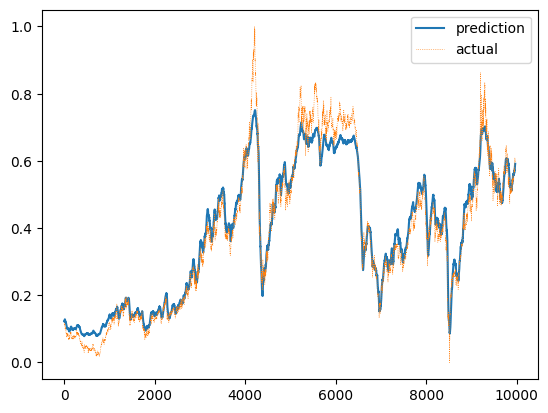

In [ ]:
plt.plot(preds, label="prediction")
plt.plot(dataset.data[step:], label="actual", ls=":", lw=0.5)
plt.legend()
plt.show()


In [ ]:
preds = []  # 예측값들을 저장하는 리스트
pred_model = torch.load(f"oil_price_model_{step}.pth")
start = dataset[0][0]
with torch.no_grad():
    for i in range(8000):
        pred = pred_model(start.unsqueeze(0))
        start = torch.cat((start[1:], pred))
        preds.append(pred.item())


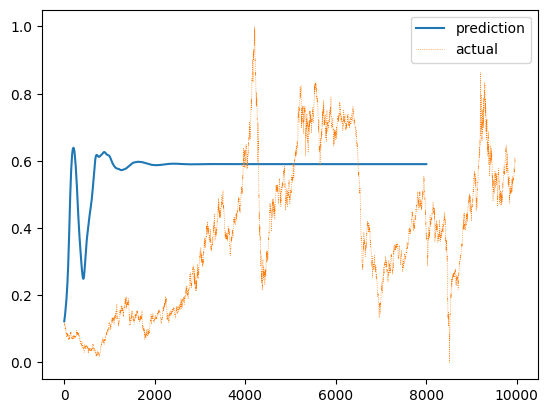

In [ ]:
plt.plot(preds, label="prediction")
plt.plot(dataset.data[step:], label="actual", ls=":", lw=0.5)
plt.legend()
plt.show()
